### Librerías

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, recall_score, f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LogisticRegression

import xgboost

import os
from datetime import date
import pickle
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# Librerías propias
import py_funs
import stats_funs
import ml_hparams_clf as bhs # Bayes search
import ml_bootstrap_clf as bc # boostraping classifiers
import ml_plotting

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

import shap

# sns.set(style='whitegrid', rc={"grid.linewidth": 0.5})
# font = {'family' : 'arial',
#         'weight' : 'normal',
#         'size'   : 22}
# plt.rc('font', **font)
plt.rcParams['figure.autolayout']= True # salva los gráficos sin cortat tiítulos de ejes

In [2]:
os.getcwd()

'/home/marcelo/GitRepos/Tesis/code'

In [3]:
# Dir creation
# Dir for saving results
# Today
now = str(date.today())

# Parent Directory path
parent_dir = "/home/marcelo/GitRepos/Tesis/" # desktop
results_dir = "/home/marcelo/GitRepos/Tesis/pred_results/" #desktop
# parent_dir = "/home/mm/Tesis/" # ssh
# results_dir = "/home/mm/Tesis/pred_results/" # ssh

# Path
path = os.path.join(results_dir, now)
try:
    os.makedirs(path)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass

path_res = os.path.join(path, 'mean_res')
# path_results = os.path.join(path, 'graphs2')
try:
    os.makedirs(path_res)
    print('Directory created!')
except FileExistsError:
    print('Directory already exsist!')
    pass


Directory already exsist!
Directory already exsist!


In [4]:
for i in ['RandomForest', 'SVM_rbf', 'SVM_poly', 'LightGBM', 'XGBoost']:
    
    path_res2 = os.path.join(path_res, i)
    # path_results = os.path.join(path, 'graphs2')
    try:
        os.makedirs(path_res2)
        print('Directory created!')
    except FileExistsError:
        print('Directory already exsist!')
        pass

Directory already exsist!
Directory already exsist!
Directory already exsist!
Directory already exsist!
Directory already exsist!


### Data

In [5]:
# Data path
data_path ='../data/' # Desktop
# df = pd.read_csv(data_path+"data_to_model.csv")
train = pd.read_csv(data_path+"train.csv")
test = pd.read_csv(data_path+"test.csv")
train.shape, test.shape

((1450, 45), (161, 45))

In [6]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'moca_total', 'aceiii_total', 'mmse_total', 'ifs_total_score',
       'mini_sea_total', 'barthel_total', 'pfeffer_total', 'cdr_sumofboxes',
       'cdr_global', 'npi_total', 'npi_total_caregiver', 'nationality',
       'country_of_residence', 'marital_status', 'n_children',
       'household_members', 'household_income', 'Job_status', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition',
       'functionality', 'income_s_NaN', 'income_s_1', 'income_s_2',
       'income_s_3', 'income_s_4', 'income_s_5', 'income_s_6', 'income_s_7',
       'income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata'],
      dtype='object')

In [7]:
def impute_mean(group):
    return group.fillna(group.mean())

nan_cols = train.isna().sum()[train.isna().sum()>0].index.tolist()

for i in nan_cols:
    train[i] = train[i].transform(impute_mean)
    
nan_cols = test.isna().sum()[test.isna().sum()>0].index.tolist()

for i in nan_cols:
    test[i] = test[i].transform(impute_mean)

In [8]:
# final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',  'ifs_total_score',
#               'mini_sea_total', 'barthel_total', 'pfeffer_total',  'npi_total', 'npi_total_caregiver',
#               'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'cognition', 'functionality',
#               'marital_status', 'n_children', 'household_members', 'household_income', 'Job_status',
#               'income_s_NaN', 'income_s_1', 'income_s_2', 'income_s_3', 'income_s_4', 'income_s_5',
#               'income_s_6', 'income_s_7','income_s_8', 'income_s_9', 'income_s_10', 'income_s_11', 'strata']

final_cols = ['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
              'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
              'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw','ace_vs', 'ace_lw', 'barthel_total',
              'pfeffer_total','cognition', 'functionality', 'marital_status', 'n_children',
              'household_members', 'household_income', 'Job_status', 'strata']

train = train[final_cols]
test = test[final_cols]
    
train.isna().sum()[train.isna().sum()>0]

Series([], dtype: int64)

In [9]:
train.columns

Index(['site', 'id', 'diagnosis', 'year_birth', 'sex', 'years_education',
       'ifs_total_score', 'mini_sea_total', 'npi_total', 'npi_total_caregiver',
       'mmse_vs', 'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw',
       'barthel_total', 'pfeffer_total', 'cognition', 'functionality',
       'marital_status', 'n_children', 'household_members', 'household_income',
       'Job_status', 'strata'],
      dtype='object')

In [10]:
train = train.drop(['site','id','strata'], axis=1)
test = test.drop(['site','id','strata'], axis=1)

### Split into AD and FTD
data = train.query("diagnosis != 'CN'")
data['diagnosis'] = data['diagnosis'].replace({'AD':0, 'FTD':1})
data = data.sample(data.shape[0], ignore_index=True)
unseen_data = test.query("diagnosis != 'CN'")
unseen_data['diagnosis'] = unseen_data['diagnosis'].replace({'AD':0, 'FTD':1})
unseen_data = unseen_data.sample(unseen_data.shape[0], ignore_index=True)

train.shape, test.shape

((1450, 23), (161, 23))

In [11]:
#### Librerías 
# cambiamos el dir de trabajo
os.chdir("/home/marcelo/GitRepos/Tesis/code") # desktop
# os.chdir("/home/mm/Tesis/code") # ssh

In [12]:
### Load Hyperparams

hparams_path = "/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_hparams/" # Desktop

rf_hp = pd.read_csv(hparams_path + "RF_hparams.csv",
                    usecols=['param_criterion', 'param_max_depth','param_max_features', 'param_min_samples_leaf',
                             'param_min_samples_split', 'param_n_estimators','params', 'mean_test_score' ,'mean_train_score'])
rf_hp= rf_hp[rf_hp['mean_test_score'] < rf_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

poly_hp = pd.read_csv(hparams_path + "SVC_Poly_hparams.csv",
                      usecols=['param_C', 'param_coef0', 'param_degree','param_gamma','params', 
                               'mean_test_score' ,'mean_train_score'])
poly_hp= poly_hp[poly_hp['mean_test_score'] < poly_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

xgb_hp = pd.read_csv(hparams_path + "xgb_hparams.csv", usecols=['param_booster', 'param_learning_rate',
       'param_max_bin', 'param_max_depth', 'param_max_leaves',
       'param_n_estimators', 'param_reg_alpha', 'param_reg_lambda',
       'param_tree_method','params', 'mean_test_score' ,'mean_train_score'])
xgb_hp= xgb_hp[xgb_hp['mean_test_score'] < xgb_hp['mean_train_score']].sort_values('mean_test_score', ascending=False).head(20)

In [14]:
rf_row = 0
rf_hp.iloc[0,:]

param_criterion                                                      entropy
param_max_depth                                                            8
param_max_features                                                         5
param_min_samples_leaf                                                  0.01
param_min_samples_split                                                 0.01
param_n_estimators                                                       500
params                     OrderedDict([('criterion', 'entropy'), ('max_d...
mean_test_score                                                     0.861135
mean_train_score                                                    0.957358
Name: 0, dtype: object

In [15]:
poly_row = 0
poly_hp.iloc[0,: ]

param_C                                                      2.055028
param_coef0                                                       100
param_degree                                                        2
param_gamma                                                     0.001
params              OrderedDict([('C', 2.0550282974397254), ('coef...
mean_test_score                                              0.857205
mean_train_score                                             0.877059
Name: 0, dtype: object

In [16]:
xgb_row=0
xgb_hp.iloc[0, :]

param_booster                                                       dart
param_learning_rate                                              0.14826
param_max_bin                                                          4
param_max_depth                                                        8
param_max_leaves                                                       8
param_n_estimators                                                   100
param_reg_alpha                                                     0.99
param_reg_lambda                                                0.707696
param_tree_method                                                 approx
params                 OrderedDict([('booster', 'dart'), ('learning_r...
mean_test_score                                                 0.855812
mean_train_score                                                 0.95939
Name: 0, dtype: object

In [17]:
## Models Hparams
# RF
rf_params= {"n_estimators": rf_hp.loc[rf_row,'param_n_estimators'],
    "criterion": rf_hp.loc[rf_row,'param_criterion'],
    "max_depth": rf_hp.loc[rf_row,'param_max_depth'],
    "min_samples_split": rf_hp.loc[rf_row,'param_min_samples_split'],
    "min_samples_leaf": rf_hp.loc[rf_row,'param_min_samples_leaf'],
    "max_features":rf_hp.loc[rf_row,'param_max_features'],
    "class_weight":"balanced", "verbose":0, "n_jobs":-1}

#Poly
poly_params = {'C': poly_hp.loc[poly_row, "param_C"],
              'gamma': poly_hp.loc[poly_row, "param_gamma"],
               'coef0': poly_hp.loc[poly_row, "param_coef0"],
               'degree': poly_hp.loc[poly_row, 'param_degree'],
              "kernel":"poly","class_weight":"balanced", "verbose":0}

#XGBOOST
xgb_params = {
    'booster': xgb_hp.loc[xgb_row, 'param_booster'],
    'tree_method': xgb_hp.loc[xgb_row, 'param_tree_method'],
    'max_leaves': xgb_hp.loc[xgb_row, 'param_max_leaves'],
    'max_depth': xgb_hp.loc[xgb_row, 'param_max_depth'],
    'max_bin': xgb_hp.loc[xgb_row, 'param_max_bin'],
    'learning_rate': xgb_hp.loc[xgb_row, 'param_learning_rate'],
    'n_estimators': xgb_hp.loc[xgb_row, 'param_n_estimators'],
    'reg_alpha': xgb_hp.loc[xgb_row, 'param_reg_alpha'],
    'reg_lambda': xgb_hp.loc[xgb_row, 'param_reg_lambda'],
    'gamma': 0.005,
    'subsample':1.0,
    'enable_categorical':True, # Supported tree methods are `gpu_hist`, `approx`, and `hist`.
    'n_jobs': -1,
    'verbosity':0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'use_label_encoder':None}

In [18]:
n_iter =1000

### Base model: Logistic Regression

In [19]:
lr_res, lr_CI_df, lr_res_r, lr_ROC_AUC, lr_CM, lr_ROC_chance, lr_empirical_p_value = bc.Bootstrap_linear_classifier(
    data, 'diagnosis', LogisticRegression(), scaler='MM', params='default', test_size=.2, n_iter=n_iter, chance_model=True)

LogisticRegression()


Iterating: 100%|██████████████████| 1000/1000 [00:43<00:00, 23.05it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:0.7238418777783712 minutes
empirical p-value: 0.0



Casting complex values to real discards the imaginary part


In [20]:
lr_res.mean()

Accuracy         0.808426
ROC_AUC          0.815160
Precision        0.743812
Recall           0.292370
Sensitivity      0.292370
Specificity      0.967745
F1               0.415917
Efron_pR2        0.240110
mcfadden_pR2     0.212419
mcfadden_apR2    0.131484
dtype: float64

In [21]:
lr_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci,mcfadden_pR2_ci,mcfadden_apR2_ci
0,0.024392,0.024059,0.027056,0.028192,0.028192,0.010951,0.030549,0.026475,0.025351,0.020945


In [22]:
lr_res_r.head()

,variables,coef_mean,coef_std,T_mean,T_std,p_val_mean,p_val_std
0,Job_status,-0.377175,0.162237,-2.295807+0.006595j,0.994500,0.116347,1.702707e-01
1,ace_lw,0.624493,0.120911,0.000007-0.000003j,0.000006,1.000000,0.000000e+00
2,ace_vs,0.608161,0.122989,0.000007-0.000003j,0.000006,1.000000,0.000000e+00
3,barthel_total,0.160646,0.194751,0.340666-0.001281j,0.442708,0.999826,1.110223e-16
4,cognition,0.229708,0.037492,0.000000+0.000000j,0.000000,1.000000,0.000000e+00


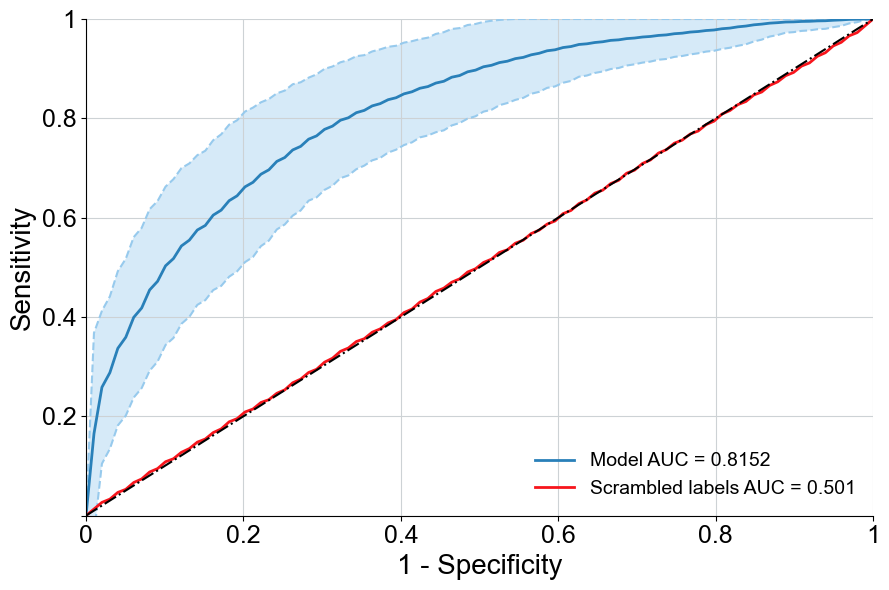

In [24]:
ml_plotting.plot_custom_roc_curve(lr_ROC_AUC, lr_ROC_chance, fname=None)

In [25]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', LogisticRegression(), params='default', test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [26]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

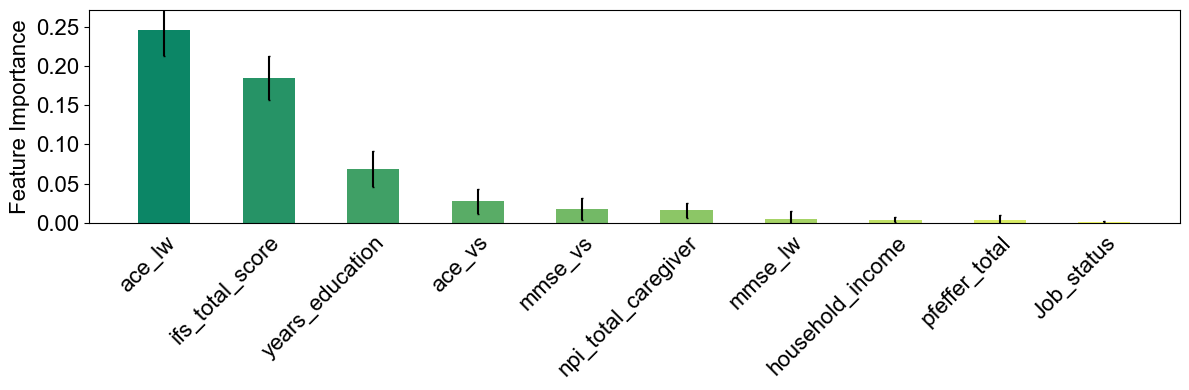

In [27]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

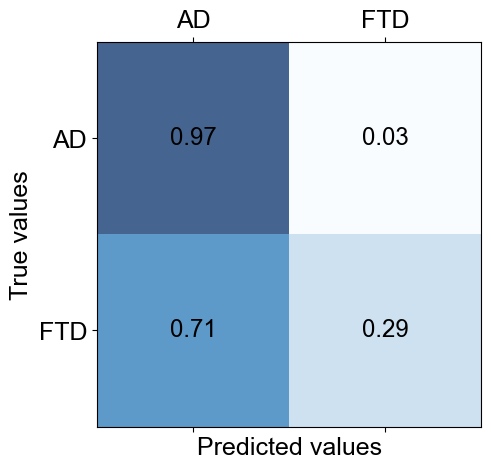

In [28]:
ml_plotting.plot_boostrap_CM(lr_CM, labels=['AD', 'FTD'],fname=None)

#### unseen data

In [29]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [30]:
np.linspace(0.1, 1, num=10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [31]:
# predict & scores
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [32]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
# unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [33]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.5417
Accuracy: 0.7664
Recall: 0.12
F1: 0.1935
Precision:0.5


In [34]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{lr_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.5417
Bootstrping test ROC score: 	0.8152


### RF Model

##### Bootstrap

In [35]:
Model_res, CI_df, Model_res_r, ROC_AUC, CM, ROC_chance, empirical_p_value = bc.Bootstrap_tree_classifier(
    data, 'diagnosis', RandomForestClassifier(), scaler='MM', params=rf_params, test_size=.2, n_iter=n_iter, chance_model=True)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, max_features=5, min_samples_leaf=0.01,
                       min_samples_split=0.01, n_estimators=500, n_jobs=-1)


Iterating: 100%|██████████████████| 1000/1000 [16:00<00:00,  1.04it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:16.00145053068797 minutes
empirical p-value: 0.0


In [36]:
path_res

'/home/marcelo/GitRepos/Tesis/pred_results/2023-09-23/mean_res'

In [37]:
Model_res.to_csv(path_res+ "/RandomForest/Model_res.csv", index=False)
Model_res.mean()

Accuracy       0.814067
ROC_AUC        0.865289
Precision      0.587447
Recall         0.731196
Sensitivity    0.731196
Specificity    0.839651
F1             0.649778
Efron_pR2      0.249165
dtype: float64

In [38]:
print("%.4f" % Model_res['ROC_AUC'].mean())


0.8653


In [39]:
CI_df.to_csv(path_res+ "/RandomForest/CI_df.csv", index=False)
CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.024114,0.021161,0.030513,0.027478,0.027478,0.022743,0.029567,0.026808


In [40]:
Model_res_r.sort_values('Importance_mean', ascending=False).to_csv(path_res+ "/RandomForest/Model_res_r.csv", index=False)
Model_res_r.sort_values('Importance_mean', ascending=False).head(10)

,variables,Importance_mean,Importance_std
20,year_birth,0.224564,0.016364
8,ifs_total_score,0.189942,0.014034
21,years_education,0.067474,0.009640
1,ace_lw,0.058162,0.006087
2,ace_vs,0.054001,0.005732
4,cognition,0.049208,0.004248
11,mmse_lw,0.029602,0.003851
9,marital_status,0.028672,0.003993
16,npi_total,0.028338,0.003464
12,mmse_vs,0.027765,0.003549


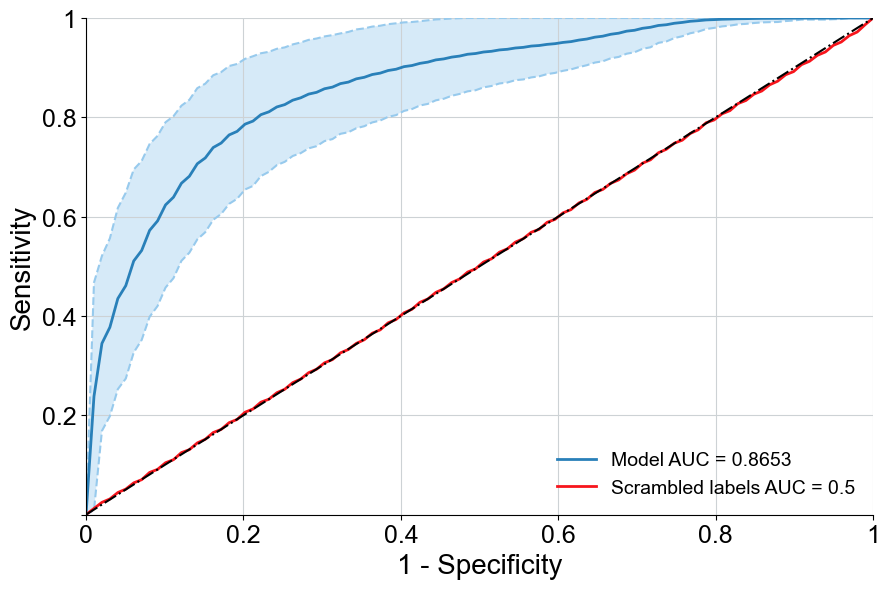

In [41]:
ml_plotting.plot_custom_roc_curve(ROC_AUC, ROC_chance, fname=path_res+ "/RandomForest/ROC_AUC_curve.png")
# Fig save?


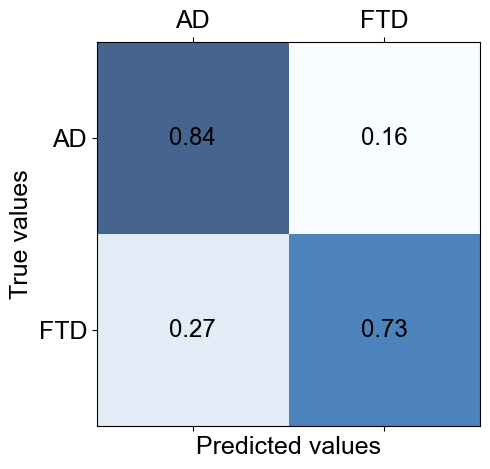

In [42]:
ml_plotting.plot_boostrap_CM(CM, labels=['AD', 'FTD'],fname=path_res+ "/RandomForest/CM.png")

##### Permutation Feature importance

In [43]:
rf_fimp = bc.permutation_FIMP(data, 'diagnosis', RandomForestClassifier(), params=rf_params, test_size=.2, n_repeats=n_iter, random_state=123)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [44]:
rf_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/RandomForest/rf_PFI.csv")
top_10p = rf_fimp.sort_values('mean', ascending=False).head(10)

In [45]:
top_10p.head()

,predictor,mean,std
3,ifs_total_score,0.116619,0.018857
0,year_birth,0.069201,0.019194
2,years_education,0.013162,0.008342
17,marital_status,0.006933,0.002956
21,Job_status,0.005251,0.002288


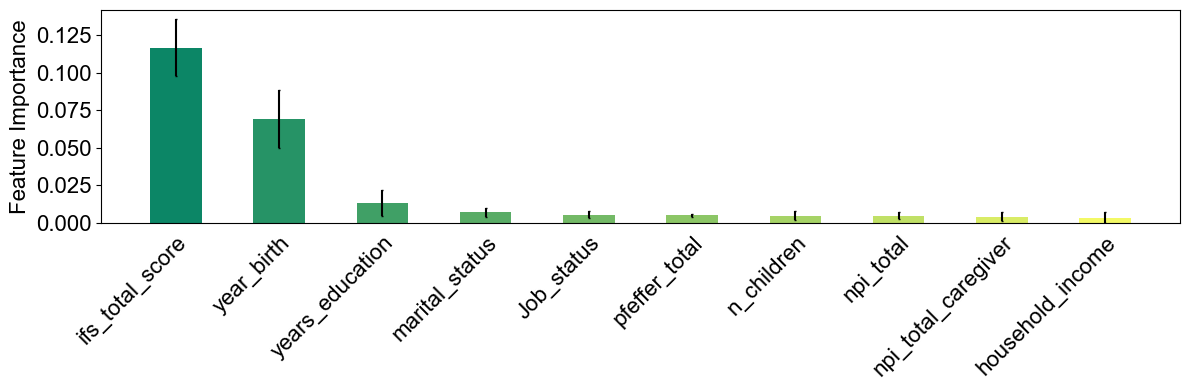

In [46]:
ml_plotting.plot_permutation_FIMP(top_10p, names='predictor', importances_col='mean', std_col='std')

In [47]:
Model_res_r.sort_values('Importance_mean', ascending=False).head()

,variables,Importance_mean,Importance_std
20,year_birth,0.224564,0.016364
8,ifs_total_score,0.189942,0.014034
21,years_education,0.067474,0.009640
1,ace_lw,0.058162,0.006087
2,ace_vs,0.054001,0.005732


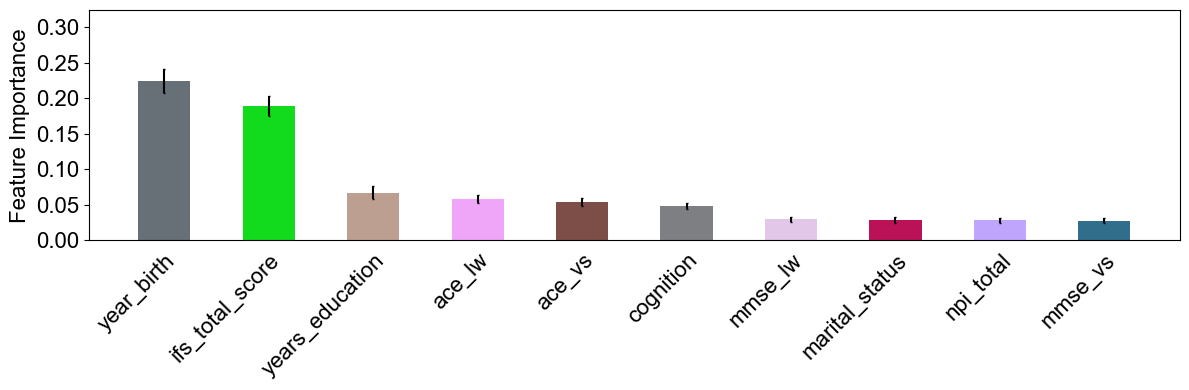

In [48]:
top_10 = Model_res_r.sort_values('Importance_mean', ascending=False).head(10)
ml_plotting.plot_bootstrap_FIMP(top_10, 'variables','Importance_mean', 'Importance_std')

##### unseen data

In [49]:
X_train, y_train = data.drop('diagnosis', axis=1), data[['diagnosis']].values.ravel()
X_test, y_test = unseen_data.drop('diagnosis', axis=1), unseen_data[['diagnosis']].values.ravel()

In [50]:
# predict & scores
rfc = RandomForestClassifier(**rf_params)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)

In [51]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/RandomForest/unseen.csv")

In [52]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}")

ROC score: 0.8112
Accuracy: 0.8598
Recall: 0.72
F1: 0.7059
Precision:0.6923


In [53]:
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{Model_res['ROC_AUC'].mean():.4f}")

Unseen Data ROC score: 		0.8112
Bootstrping test ROC score: 	0.8653


#### Shapley

In [54]:
# compute SHAP values
explainer = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist(), feature_perturbation="interventional")
shap_values = explainer(X_test, check_additivity=False)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


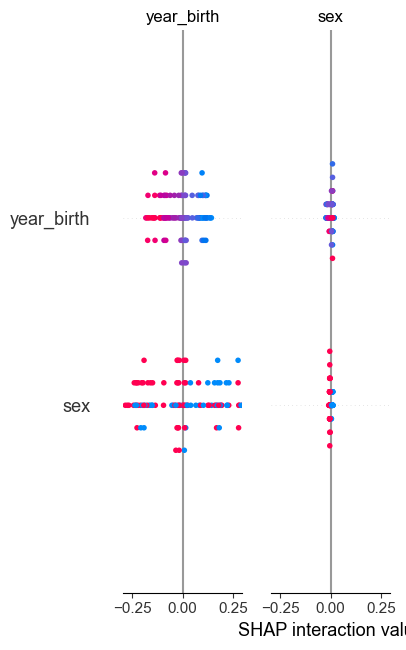

In [55]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

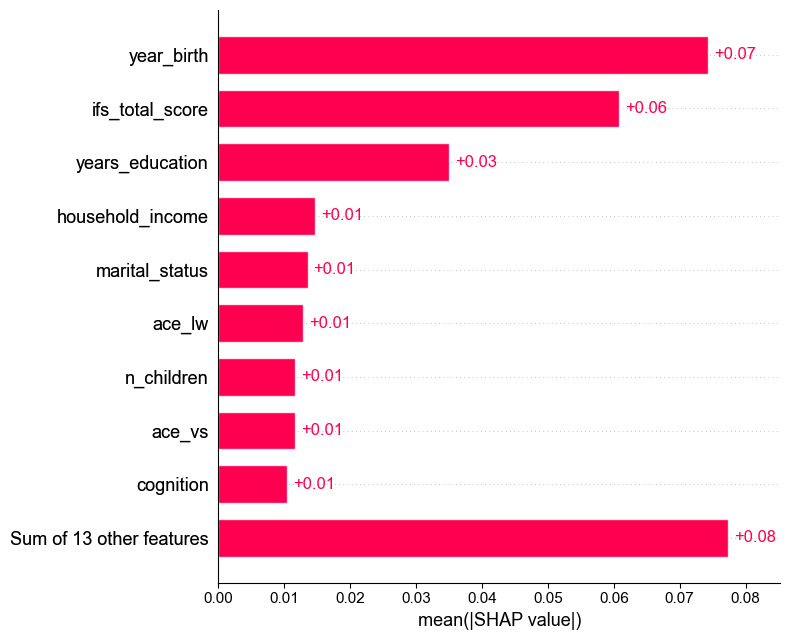

In [56]:
shap.plots.bar(shap_values[:,:,1])

In [57]:
# shap.plots.beeswarm(shap_values[:,:,1])

In [58]:
# # compute SHAP values
# explainer2 = shap.explainers.Tree(rfc, X_train, feature_names=X_train.columns.tolist())
# shap_values2 = explainer(X_test, check_additivity=False)

In [59]:
# shap.summary_plot(shap_values2[:,:,1])

In [60]:
# shap.plots.bar(shap_values2[:,:,1])

In [61]:

# # Convertir shap_values en un DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

# # Guardar el DataFrame en un archivo CSV
# shap_df.to_csv('shap_values.csv', index=False)


In [62]:
# shap_values2[:,:,1]

### SVM - Poly

#### Bootstrap

In [63]:
p_Model_res, p_CI_df, p_Model_res_r, p_ROC_AUC, p_CM, p_ROC_chance, p_empirical_p_value = bc.Bootstrap_SVC_classifier(
    data, 'diagnosis', SVC(), params=poly_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

SVC(C=2.0550282974397254, class_weight='balanced', coef0=100, degree=2,
    gamma=0.001, kernel='poly', verbose=0)


Iterating: 100%|██████████████████| 1000/1000 [00:39<00:00, 25.03it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:0.665900715192159 minutes
empirical p-value: 0.0


In [64]:
p_Model_res.to_csv(path_res+ "/SVM_poly/poly_Model_res.csv", index=False)
p_Model_res.mean()

Accuracy       0.738164
ROC_AUC        0.731961
Precision      0.466643
Recall         0.720217
Sensitivity    0.720217
Specificity    0.743705
F1             0.564954
dtype: float64

In [65]:
p_CI_df.to_csv(path_res+ "/SVM_poly/poly_CI_df.csv", index=False)
p_CI_df.mean()

Accuracy_ci       0.027249
ROC_AUC_ci        0.027454
Precision_ci      0.030921
Recall_ci         0.027823
Sensitivity_ci    0.027823
Specificity_ci    0.027060
F1_ci             0.030728
dtype: float64

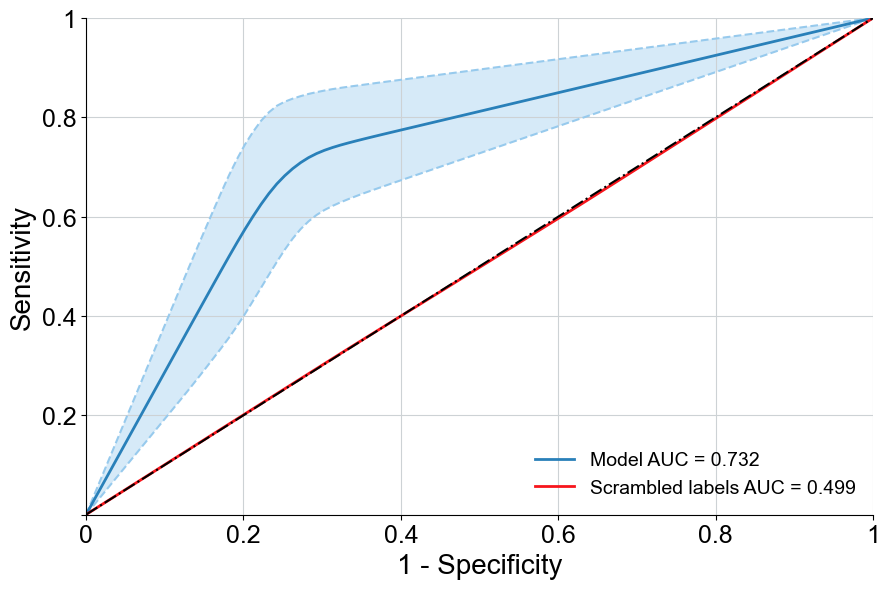

In [66]:
ml_plotting.plot_custom_roc_curve(p_ROC_AUC, p_ROC_chance, fname=path_res+ "/SVM_poly/poly_ROC_AUC_curve.png")

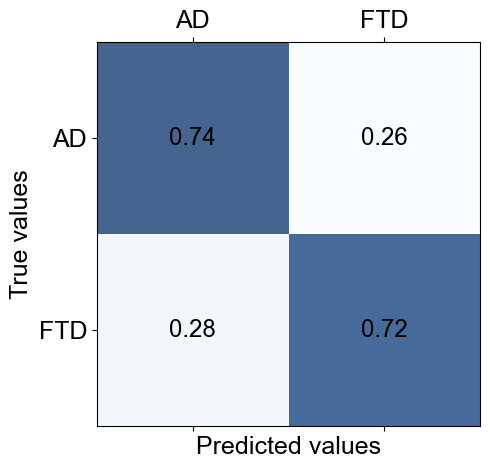

In [67]:
ml_plotting.plot_boostrap_CM(p_CM, labels=['AD', 'FTD'],fname=path_res+ "/SVM_poly/poly_CM.png")

#### Permutation Feature importance

In [68]:
p_fimp = bc.permutation_FIMP( data, 'diagnosis', SVC(), params=poly_params, test_size=.3, n_repeats=n_iter, random_state=123)
p_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/SVM_poly/poly_PFI.csv")
top_10_poly = p_fimp.sort_values('mean', ascending=False).head(10)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


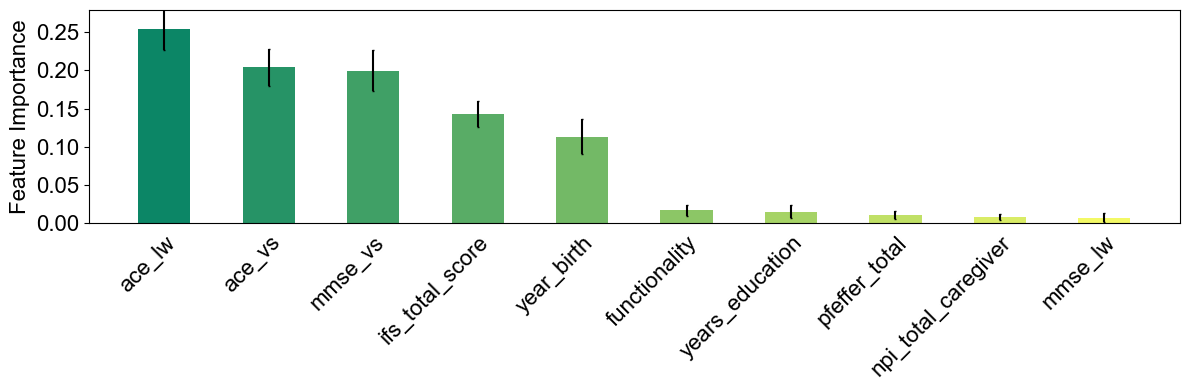

In [69]:
ml_plotting.plot_permutation_FIMP(top_10_poly, names='predictor', importances_col='mean', std_col='std')

#### Unseen data

In [70]:
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [71]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/SVM_poly/poly_PFI.csv")

In [72]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{p_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.7824
Accuracy: 0.7944
Recall: 0.76
F1: 0.6333
Precision:0.5429

Unseen Data ROC score: 		0.7824
Bootstrping test ROC score: 	0.7320


#### Shapley

In [73]:
poly_params['probability'] = True

In [74]:
# compute SHAP values
poly = SVC(**poly_params)
poly=poly.fit(X_train, y_train)

masker=shap.maskers.Independent(X_train, max_samples=1)
# explainer = shap.KernelExplainer(model=svc_rbf.predict, data=X_train, masker=masker)
explainer = shap.KernelExplainer(model=poly.predict_proba, data=masker.data)
shap_values = explainer.shap_values(X_train, masker = masker)
# explainer = shap.KernelExplainer(model.predict, X_train_summary, masker=background)

X does not have valid feature names, but SVC was fitted with feature names


  0%|          | 0/974 [00:00<?, ?it/s]

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid feature names, but SVC was fitted with feature names
X does not have valid fea

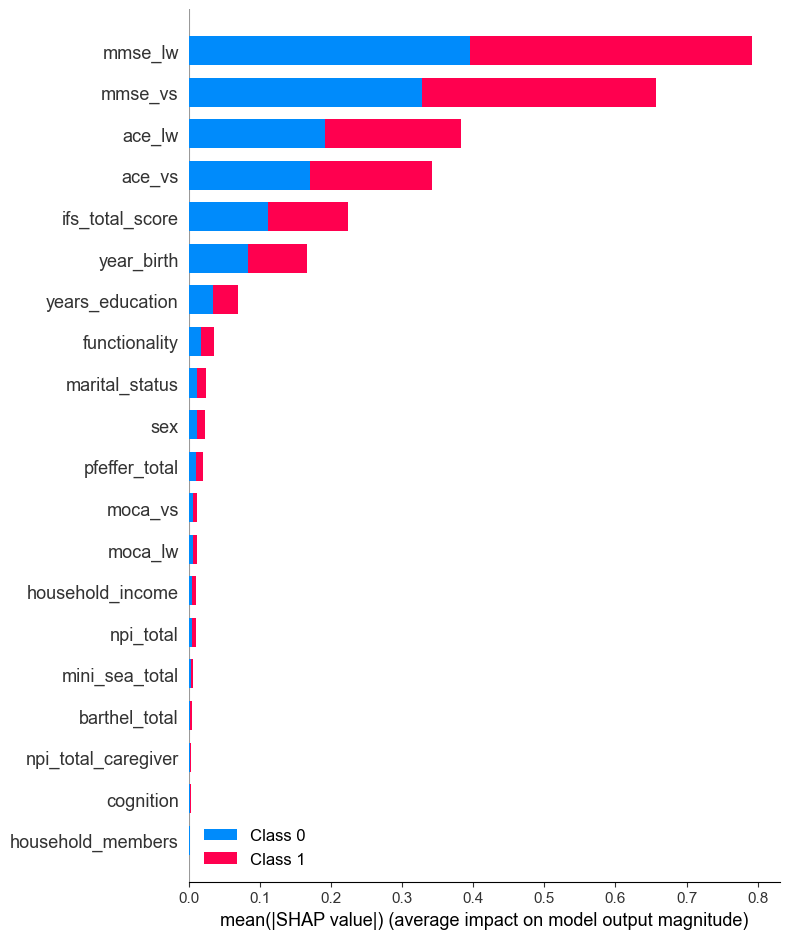

In [75]:
shap.summary_plot(shap_values, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:,:1], feature_names=X_train.columns)

### XGBoost

#### Bootstrap

In [76]:
xgb_Model_res, xgb_CI_df, xgb_Model_res_r, xgb_ROC_AUC, xgbCM, xgb_ROC_chance, xgb_empirical_p_value, _ = bc.Bootstrap_XGB_classifier(
    data, 'diagnosis',  params=xgb_params, test_size=.2, scaler='MM', n_iter=n_iter, chance_model=True)

Iterating: 100%|██████████████████| 1000/1000 [16:02<00:00,  1.04it/s]

singular_matrix_errors (droped from results): 0
Eleapsed time:16.042906848589578 minutes
empirical p-value: 0.0


In [77]:
xgb_Model_res.to_csv(path_res+ "/XGBoost/xgb_Model_res.csv", index=False)
xgb_Model_res.mean()

Accuracy       0.840344
ROC_AUC        0.868553
Precision      0.705737
Recall         0.562674
Sensitivity    0.562674
Specificity    0.926067
F1             0.623352
Efron_pR2      0.366206
dtype: float64

In [78]:
xgb_Model_res_r.sort_values('Importance_gain_mean', ascending=False).to_csv(path_res+"/XGBoost/xgb_Model_res_r.csv", index=False)
xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
8,ifs_total_score,91.833,8.880201,3.579743,0.572415
19,year_birth,66.391,9.140003,5.007390,0.980306
15,npi_total,55.692,10.018758,1.901346,0.389528
20,years_education,54.536,9.134010,1.736362,0.351829
10,mini_sea_total,48.336,8.194648,1.022980,0.258421
16,npi_total_caregiver,44.273,7.120897,1.417472,0.265960
13,moca_vs,40.216,9.708739,0.999091,0.294929
17,pfeffer_total,33.722,8.629321,1.191377,0.387087
18,sex,33.325,8.326626,0.760116,0.170592
5,functionality,31.559,8.443566,0.845669,0.245686


In [79]:
xgb_CI_df.to_csv(path_res+ "/XGBoost/xgb_CI_df.csv", index=False)
xgb_CI_df

,Accuracy_ci,ROC_AUC_ci,Precision_ci,Recall_ci,Sensitivity_ci,Specificity_ci,F1_ci,Efron_pR2_ci
0,0.022703,0.020943,0.028245,0.030746,0.030746,0.016218,0.030032,0.02986


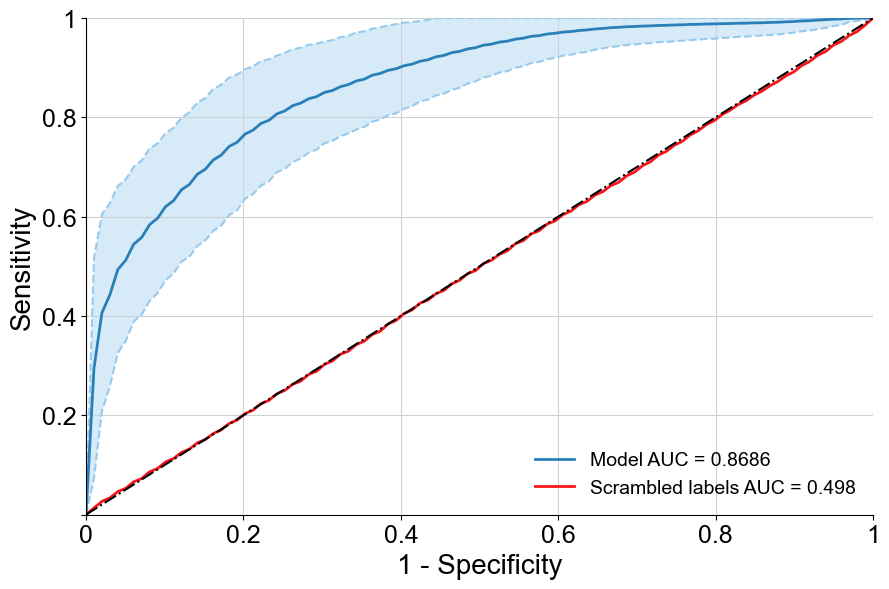

In [80]:
ml_plotting.plot_custom_roc_curve(xgb_ROC_AUC, xgb_ROC_chance, fname=path_res+ "/XGBoost/xgb_ROC.png")

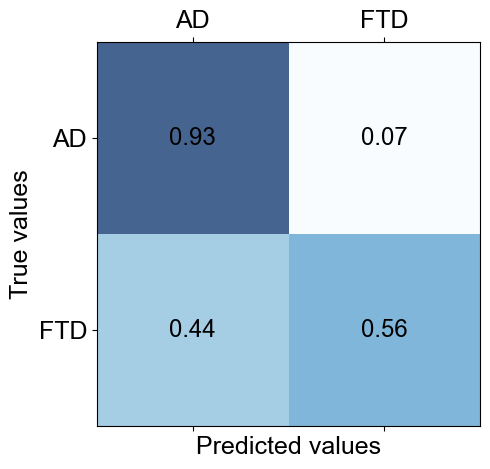

In [81]:
ml_plotting.plot_boostrap_CM(xgbCM, labels=['AD', 'FTD'],fname=path_res+ "/XGBoost/xgb_CM.png")

#### Permutation Feature importance

In [82]:
xgb_fimp = bc.permutation_FIMP( data, 'diagnosis', xgboost.XGBClassifier(), params=xgb_params, test_size=.3, n_repeats=1000, random_state=123)
xgb_fimp.sort_values('mean', ascending=False).to_csv(path_res+ "/XGBoost/xgb_PFI.csv")
top_10_xgb=xgb_fimp.sort_values('mean', ascending=False).head(10)

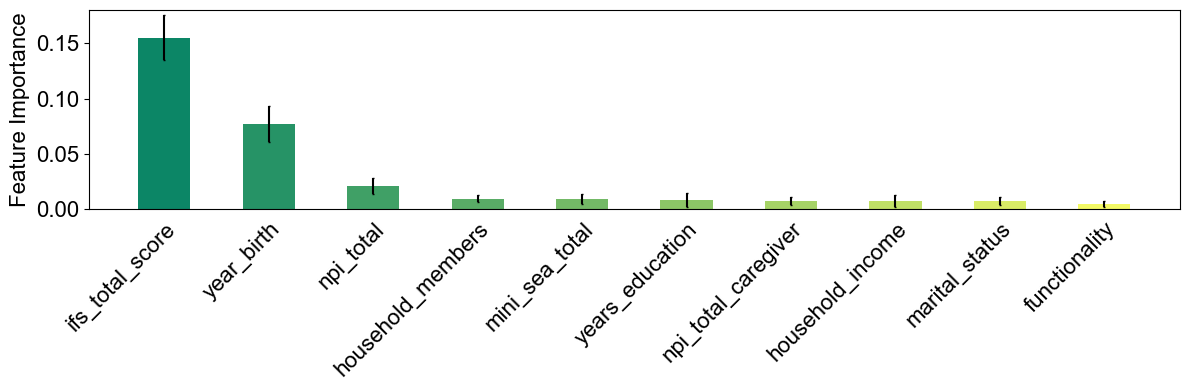

In [83]:
ml_plotting.plot_permutation_FIMP(top_10_xgb, names='predictor', importances_col='mean', std_col='std')

In [84]:
xgb_Model_res_r

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
0,Job_status,27.135000,7.667305,2.227776,0.820807
1,ace_lw,12.580321,5.696563,0.813027,0.415507
2,ace_vs,13.271271,6.220198,0.975557,0.424869
3,barthel_total,2.860927,1.992824,0.739780,0.526487
4,cognition,20.683000,7.033205,1.981759,0.778756
5,functionality,31.559000,8.443566,0.845669,0.245686
6,household_income,29.288000,8.390558,1.477646,0.384390
7,household_members,26.579000,9.128586,1.086562,0.331273
8,ifs_total_score,91.833000,8.880201,3.579743,0.572415
9,marital_status,25.324000,6.746743,3.128169,0.871776


In [85]:
top_10_xgb = xgb_Model_res_r.sort_values('Importance_f_score_mean', ascending=False).head(10)
top_10_xgb

,variables,Importance_f_score_mean,Importance_f_score_std,Importance_gain_mean,Importance_gain_std
8,ifs_total_score,91.833,8.880201,3.579743,0.572415
19,year_birth,66.391,9.140003,5.007390,0.980306
15,npi_total,55.692,10.018758,1.901346,0.389528
20,years_education,54.536,9.134010,1.736362,0.351829
10,mini_sea_total,48.336,8.194648,1.022980,0.258421
16,npi_total_caregiver,44.273,7.120897,1.417472,0.265960
13,moca_vs,40.216,9.708739,0.999091,0.294929
17,pfeffer_total,33.722,8.629321,1.191377,0.387087
18,sex,33.325,8.326626,0.760116,0.170592
5,functionality,31.559,8.443566,0.845669,0.245686


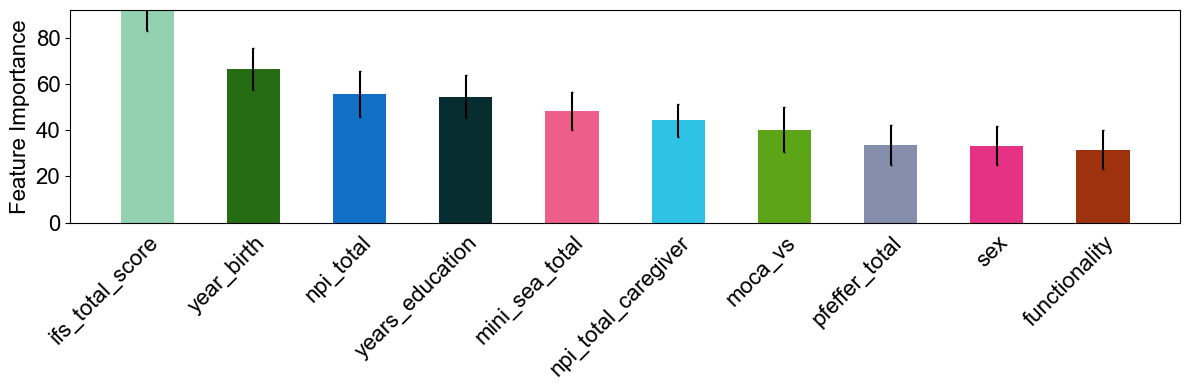

In [86]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_f_score_mean', 'Importance_f_score_std')

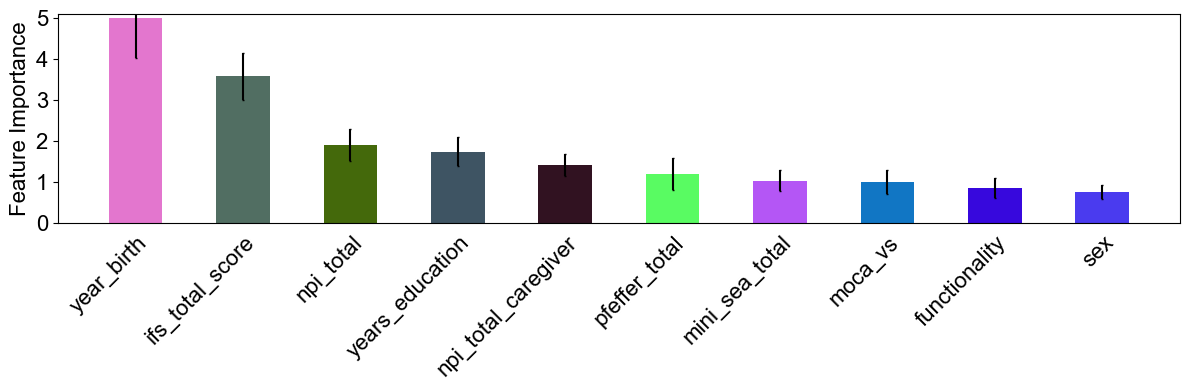

In [87]:
ml_plotting.plot_bootstrap_FIMP(top_10_xgb, 'variables','Importance_gain_mean', 'Importance_gain_std')

#### Unseen data

In [88]:
xgb = xgboost.XGBClassifier(**xgb_params)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
roc = np.round(roc_auc_score(y_test, y_pred), 4)
acc = np.round(accuracy_score(y_test, y_pred), 4)
rec = np.round(recall_score(y_test, y_pred),4)
f1 = np.round(f1_score(y_test, y_pred), 4)
prec = np.round(precision_score(y_test, y_pred), 4)


In [89]:
unseen_df = pd.DataFrame([roc, acc, rec, f1, prec]).T
unseen_df.columns= ['ROC AUC', 'Accuracy', 'Recall', 'F1', 'Precision']
unseen_df.to_csv(path_res+ "/XGBoost/xgb_PFI.csv")

In [90]:
print(f"ROC score: {roc}\nAccuracy: {acc}\nRecall: {rec}\nF1: {f1}\nPrecision:{prec}\n")
print(f"Unseen Data ROC score: \t\t{roc}\nBootstrping test ROC score: \t{xgb_Model_res['ROC_AUC'].mean():.4f}")

ROC score: 0.6878
Accuracy: 0.8411
Recall: 0.4
F1: 0.5405
Precision:0.8333

Unseen Data ROC score: 		0.6878
Bootstrping test ROC score: 	0.8686


#### Shapley

In [92]:
# # compute SHAP values
# explainer = shap.explainers.Tree(xgb, X_train, feature_names=X_train.columns.tolist())
# shap_values = explainer(X_train, check_additivity=False)

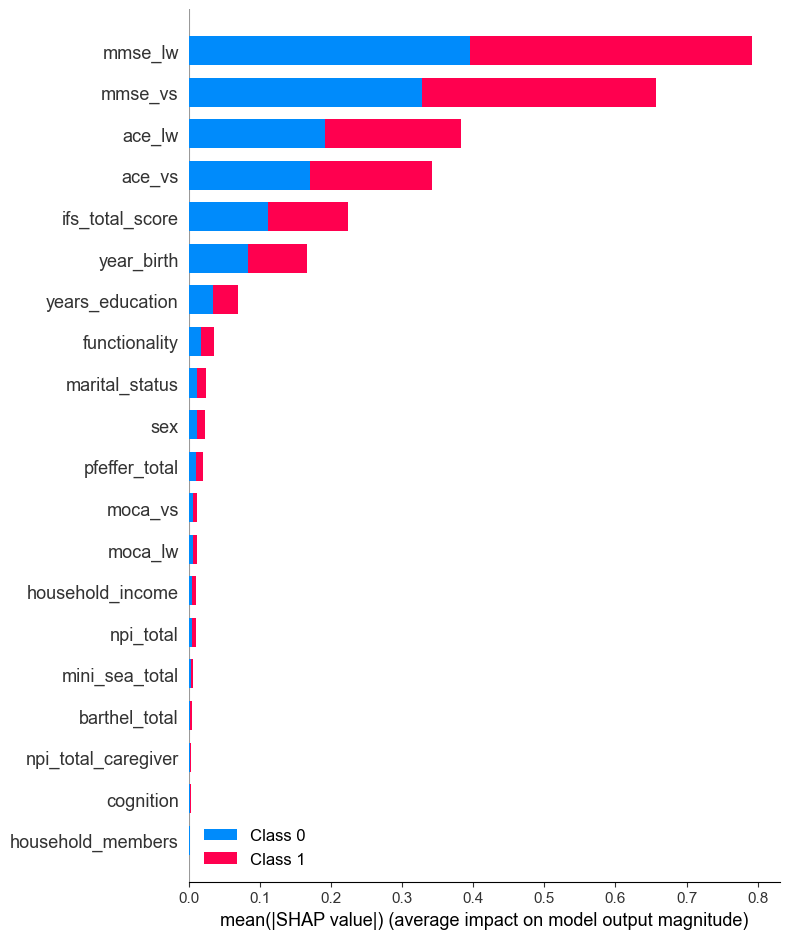

In [93]:
shap.summary_plot(shap_values, feature_names=X_train.columns)

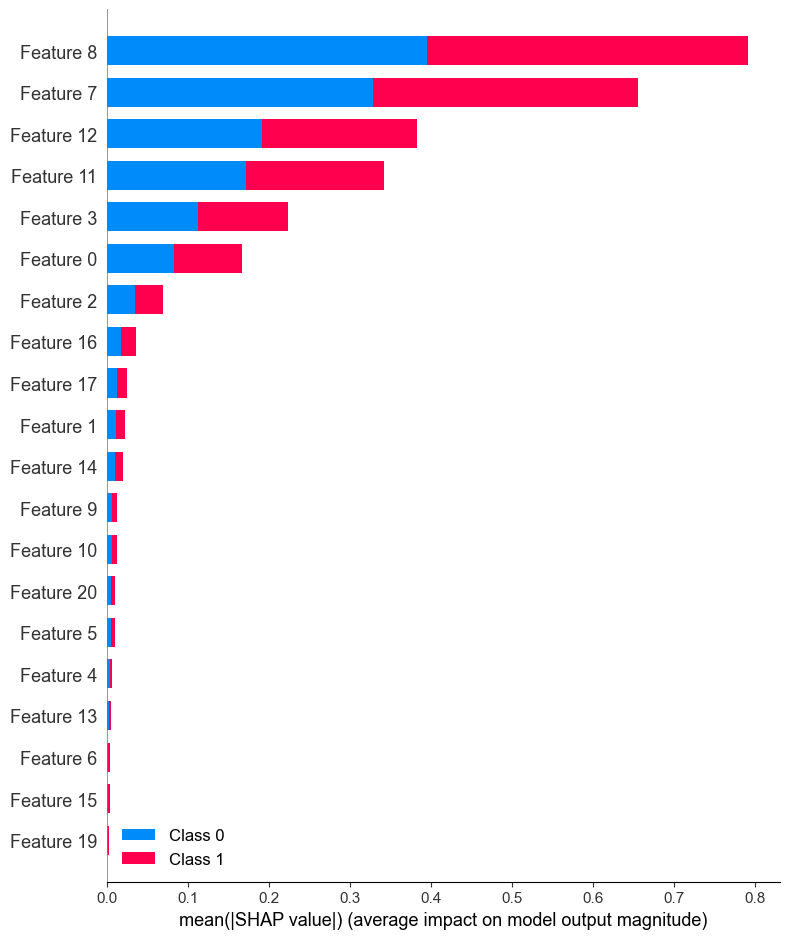

In [94]:
shap.summary_plot(shap_values)

In [112]:
#shap.plots.bar(shap_values)

Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 featur

### Sequential feature selector

#### RF

In [96]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

In [97]:
n_splits = 3
cv = StratifiedKFold(n_splits=n_splits)

In [98]:
rf_params

{'n_estimators': 500,
 'criterion': 'entropy',
 'max_depth': 8,
 'min_samples_split': 0.01,
 'min_samples_leaf': 0.01,
 'max_features': 5,
 'class_weight': 'balanced',
 'verbose': 0,
 'n_jobs': -1}

In [99]:
sfs_rfc = SFS(RandomForestClassifier(class_weight= 'balanced'), 
           k_features=20, 
           forward=True, 
           floating=False, 
           verbose=1,
           cv=cv, n_jobs =-1)

In [100]:
sfs_rfc = sfs_rfc.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  22 | elapsed:    1.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    1.5s finished
Features: 1/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  21 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.7s finished
Features: 2/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed:    0.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
Features: 3/20[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  19 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:    0.8s finished
Features: 4/20[Parallel(n_jobs=-1)]: Using

In [101]:
pd.DataFrame.from_dict(sfs_rfc.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(3,)","[0.7661538461538462, 0.796923076923077, 0.7685...",0.777198,"(ifs_total_score,)",0.031461,0.013981,0.009886
2,"(3, 4)","[0.8, 0.8184615384615385, 0.7932098765432098]",0.80389,"(ifs_total_score, mini_sea_total)",0.02401,0.01067,0.007545
3,"(3, 4, 6)","[0.803076923076923, 0.8276923076923077, 0.8024...",0.811079,"(ifs_total_score, mini_sea_total, npi_total_ca...",0.026441,0.01175,0.008308
4,"(3, 4, 6, 17)","[0.8338461538461538, 0.8369230769230769, 0.824...",0.831614,"(ifs_total_score, mini_sea_total, npi_total_ca...",0.012327,0.005478,0.003873
5,"(3, 4, 5, 6, 17)","[0.8523076923076923, 0.8215384615384616, 0.836...",0.836755,"(ifs_total_score, mini_sea_total, npi_total, n...",0.028273,0.012564,0.008884
6,"(1, 3, 4, 5, 6, 17)","[0.8615384615384616, 0.8338461538461538, 0.830...",0.841877,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.03146,0.01398,0.009885
7,"(1, 3, 4, 5, 6, 14, 17)","[0.8523076923076923, 0.84, 0.8240740740740741]",0.838794,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.026009,0.011558,0.008173
8,"(1, 3, 4, 5, 6, 14, 17, 19)","[0.8492307692307692, 0.8307692307692308, 0.811...",0.830576,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.034455,0.015311,0.010826
9,"(1, 3, 4, 5, 6, 13, 14, 17, 19)","[0.8553846153846154, 0.8369230769230769, 0.799...",0.830563,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.052434,0.023301,0.016476
10,"(1, 3, 4, 5, 6, 13, 14, 15, 17, 19)","[0.8369230769230769, 0.8338461538461538, 0.842...",0.837787,"(sex, ifs_total_score, mini_sea_total, npi_tot...",0.008152,0.003623,0.002562


In [102]:
from sklearn.feature_selection import SequentialFeatureSelector as ssfs
from sklearn.feature_selection import RFECV

In [103]:
rfecv_rf = RFECV(RandomForestClassifier(class_weight= 'balanced'), step=1, min_features_to_select=5, cv=cv, scoring='roc_auc', verbose=1,
      n_jobs=-1, importance_getter='auto')

In [104]:
rfecv_rf=rfecv_rf.fit(X_train, y_train)

In [105]:
X_train.columns[rfecv_rf.support_]

Index(['year_birth', 'sex', 'years_education', 'ifs_total_score',
       'mini_sea_total', 'npi_total', 'npi_total_caregiver', 'mmse_vs',
       'mmse_lw', 'moca_vs', 'moca_lw', 'ace_vs', 'ace_lw', 'barthel_total',
       'pfeffer_total', 'cognition', 'functionality', 'marital_status',
       'n_children', 'household_members', 'household_income', 'Job_status'],
      dtype='object')

### XBoost

In [106]:
# sfs_xgb = SFS(xgboost.XGBClassifier(), 
#            k_features=20, 
#            forward=True, 
#            floating=False, 
#            verbose=1,
#            cv=cv, n_jobs =-1)

In [107]:
# sfs_xgb = sfs_xgb.fit(X_train, y_train)

In [108]:
# pd.DataFrame.from_dict(sfs_xgb.get_metric_dict()).T

In [109]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

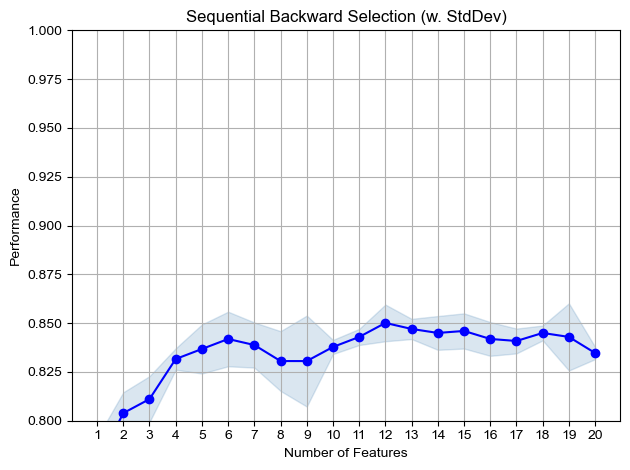

In [110]:
fig1 = plot_sfs(sfs_rfc.get_metric_dict(), kind='std_dev')


plt.ylim([0.8, 1])
# plt.figure(figsize=(13, 3))
plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()
plt.show()

In [111]:
# fig2 = plot_sfs(sfs_xgb.get_metric_dict(), kind='std_dev')


# plt.ylim([0.8, 1])
# # plt.figure(figsize=(13, 3))
# plt.title('Sequential Backward Selection (w. StdDev)')
# plt.grid()
# plt.show()